In [1]:
import numpy as np
import networkx as nx
from loguru import logger as log
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import qtree 
import utils
import utils_qaoa as qaoa

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


In [40]:
def get_test_graph(S):
    G = nx.triangular_lattice_graph(S, S)
    #G = nx.grid_2d_graph(S, (S+1)//2)
    # remove grid labelling
    gen = (x for x in range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, lambda x: next(gen))
    return G

def get_test_qaoa(S, p):
    G = get_test_graph(S)
    N = G.number_of_nodes()
    beta, gamma = [np.pi/3]*p, [np.pi/2]*p
    qc = qaoa.get_qaoa_circuit(G, beta, gamma)
    return qc, N

def get_test_expr_graph(S, p):
    qc, N = get_test_qaoa(S, p)
    graph = qtree.graph_model.circ2graph(N, qc)
    return graph, N

def get_optimized_expr(S, p):
    graph, N = get_test_expr_graph(S, p)
    graph_opt, nghs = _optimise_graph(graph)
    return graph_opt, nghs, N

def _optimise_graph(graph):
    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    graph_opt, slice_dict = utils.reorder_graph(graph, peo)
    return graph_opt, nghs

def get_splitted_graph(S, p, pars):
    graph, N = get_test_expr_graph(S, p)
    idxs, graph = qtree.graph_model.split_graph_by_metric(graph)
    graph_opt, nghs = _optimise_graph(graph)
    return graph, nghs, N

def get_cost_of_splitted(S, p, pars):
    graph, nghs, N = get_splitted_graph(S, p)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

def get_cost_of_task(S, p=1):
    graph_opt, nghs, N = get_optimized_expr(S, p)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

[autoreload of qtree.graph_model.graph_model failed: Traceback (most recent call last):
  File "/usr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py", line 443, in <module>
    @profile
NameError: name 'profile' is not defined
]
[autoreload of utils failed: Traceback (most recent call last):
  File "/usr/lib/pytho

## Example of per-step cost

2020-03-06 18:00:04,586- INFO•	Generated graph with 1540 nodes and 3390 edges


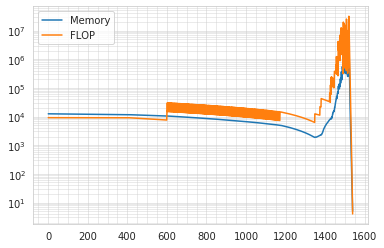

In [39]:
mems, flops, nghs, N = get_cost_of_task(20)
utils.plot_cost(mems, flops)

## Cost vs qubits size 

In [20]:
print(N)
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')
    
def get_est(xs, vals):
    mem_est = np.polyfit(np.log(xs), np.log(vals), 2)
    mem_est = np.poly1d(mem_est)
    est = np.linspace(20,1e3, 100)
    est = np.log(est)
    mem_est = mem_est(est)
    return np.exp(est),  np.exp(mem_est)

2020-03-06 17:23:10,249- INFO•	Generated graph with 174 nodes and 399 edges
2020-03-06 17:23:10,877- INFO•	Generated graph with 238 nodes and 553 edges
2020-03-06 17:23:11,542- INFO•	Generated graph with 312 nodes and 732 edges
2020-03-06 17:23:12,577- INFO•	Generated graph with 396 nodes and 936 edges
2020-03-06 17:23:14,207- INFO•	Generated graph with 490 nodes and 1165 edges
2020-03-06 17:23:16,760- INFO•	Generated graph with 594 nodes and 1419 edges
2020-03-06 17:23:20,455- INFO•	Generated graph with 708 nodes and 1698 edges
2020-03-06 17:23:26,380- INFO•	Generated graph with 832 nodes and 2002 edges
2020-03-06 17:23:34,709- INFO•	Generated graph with 966 nodes and 2331 edges
2020-03-06 17:23:45,785- INFO•	Generated graph with 1110 nodes and 2685 edges
2020-03-06 17:24:00,405- INFO•	Generated graph with 1264 nodes and 3064 edges
2020-03-06 17:24:20,233- INFO•	Generated graph with 1428 nodes and 3468 edges


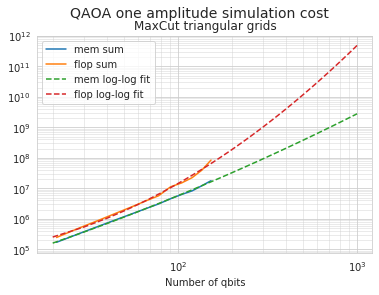

In [14]:
sizes = np.arange(5,17,1)
results = [
   get_cost_of_task(s) for s in sizes
]
def plot_theory(results):
    sums = [[sum(x) for x in y[:3]] for y in results]
    memsums, flopsums, nghssums = zip(*sums)
    ns = list(zip(*results))[3]

    est, mem_est = get_est(ns, memsums)
    est, flop_est = get_est(ns, flopsums)


    plt.plot(ns, memsums, label='mem sum')
    plt.plot(ns, flopsums, label='flop sum')
    plt.plot(est, mem_est, '--', label='mem log-log fit')
    plt.plot(est, flop_est, '--', label='flop log-log fit')

    plt.xlabel('Number of qbits')
    plt.yscale('log')
    plt.xscale('log')
    plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
    plt.title('MaxCut triangular grids')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

plot_theory(results)

In [ ]:
plt.plot(sizes, ns)

## Cost with respect to depth


In [19]:
psize = 5
Ssize = 6

costs_with_p = []
for p in range(1, 1+psize):
    for S in range(1, 1+Ssize):
        costs = get_cost_of_task(S, p)
        costs_with_p.append(costs)
       

2020-03-06 17:27:55,545- INFO•	Generated graph with 18 nodes and 33 edges
2020-03-06 17:27:55,554- INFO•	Generated graph with 42 nodes and 87 edges
2020-03-06 17:27:55,602- INFO•	Generated graph with 76 nodes and 166 edges
2020-03-06 17:27:55,794- INFO•	Generated graph with 120 nodes and 270 edges
2020-03-06 17:27:55,972- INFO•	Generated graph with 174 nodes and 399 edges
2020-03-06 17:27:56,331- INFO•	Generated graph with 238 nodes and 553 edges
2020-03-06 17:27:57,020- INFO•	Generated graph with 30 nodes and 63 edges
2020-03-06 17:27:57,050- INFO•	Generated graph with 72 nodes and 168 edges
2020-03-06 17:27:57,390- INFO•	Generated graph with 132 nodes and 322 edges
2020-03-06 17:27:57,725- INFO•	Generated graph with 210 nodes and 525 edges
2020-03-06 17:27:58,233- INFO•	Generated graph with 306 nodes and 777 edges
2020-03-06 17:27:59,331- INFO•	Generated graph with 420 nodes and 1078 edges
2020-03-06 17:28:01,349- INFO•	Generated graph with 42 nodes and 93 edges
2020-03-06 17:28:01,3

In [27]:
print(costs_with_p)

[((122, 120, 118, 116, 114, 112, 110, 104, 98, 94, 88, 74, 82, 68, 42, 32, 10, 5.0), (96, 96, 96, 96, 96, 96, 96, 88, 80, 144, 136, 224, 120, 104, 72, 56, 12, 4.0), [1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 1], 3), ((320, 318, 316, 314, 312, 310, 308, 306, 304, 302, 300, 298, 296, 290, 284, 278, 272, 266, 262, 256, 242, 242, 228, 222, 214, 200, 190, 176, 170, 162, 148, 142, 134, 120, 110, 90, 80, 62, 56, 46, 10, 5.0), (240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 232, 224, 216, 208, 200, 384, 376, 704, 352, 336, 640, 312, 296, 280, 264, 496, 240, 224, 416, 200, 184, 168, 136, 120, 96, 160, 64, 12, 4.0), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 1], 6), ((610, 608, 606, 604, 602, 600, 598, 596, 594, 592, 590, 588, 586, 584, 582, 580, 578, 576, 574, 572, 570, 564, 558, 552, 546, 540, 534, 528, 522, 516, 512, 506, 492, 492, 478, 472, 464, 450, 444, 436, 422, 416, 408, 394, 388, 

(4, 5, 6)


Text(0.5, 0.98, 'Cost dependence for different p')

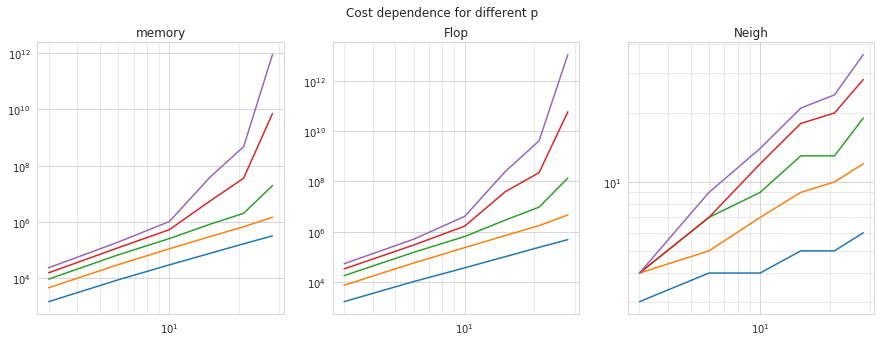

In [34]:

#costs_with_p_ = [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_p]
data = np.array(list(zip(*costs_with_p)))

data = data.reshape(4, psize, Ssize)
print(data.shape)

fig, axs = plt.subplots(1,3, figsize=(15, 5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(psize):
    plt.plot(data[-1,i], data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(psize):
    plt.plot(data[-1,i], data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(psize):
    plt.plot(data[-1,i], data[2,i])

plt.suptitle('Cost dependence for different p')


## Profiling actual simulation

In [ ]:
from pyrofiler import mem_util, timed, timing
from pyrofiler.callbacks import append_to

In [ ]:
profile = {}

@mem_util(description='mem', callback=append_to(profile))
@timed('time', callback=append_to(profile))
@log.catch()
def simulate_circ(circuit, n_qubits):
    buckets, data_dict, bra_vars, ket_vars = qtree.optimizer.circ2buckets(
        n_qubits, circuit)

    graph = qtree.graph_model.buckets2graph(
        buckets,
        ignore_variables=bra_vars+ket_vars)

    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    peo = qtree.graph_model.indices_to_vars(peo, graph)
    
    # place bra and ket variables to beginning, so these variables
    # will be contracted first
    #peo, treewidth = qtree.graph_model.get_peo(graph)

    peo = ket_vars + bra_vars + peo
    perm_buckets, perm_dict = qtree.optimizer.reorder_buckets(buckets, peo)

    # extract bra and ket variables from variable list and sort according
    # to qubit order
    ket_vars = sorted([perm_dict[idx] for idx in ket_vars], key=str)
    bra_vars = sorted([perm_dict[idx] for idx in bra_vars], key=str)

    # Take the subtensor corresponding to the initial state
    initial_state = target_state = 0
    slice_dict = qtree.utils.slice_from_bits(initial_state, ket_vars)
    slice_dict.update(
        qtree.utils.slice_from_bits(target_state, bra_vars)
    )
    sliced_buckets = qtree.np_framework.get_sliced_np_buckets(
        perm_buckets, data_dict, slice_dict)
    
    with timing('time_raw', callback=append_to(profile)):
        result = qtree.optimizer.bucket_elimination(
            sliced_buckets, qtree.np_framework.process_bucket_np)
        

In [ ]:
for key in profile:
    profile[key] = []
    
profile['N'] = []
sizes = np.arange(5,27) 

for S in sizes[:]:
    qc, N = get_test_qaoa(S)
    profile['N'].append(N)
    print(N,'qubits')
    result = simulate_circ(qc, N)

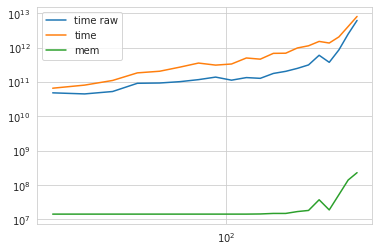

In [81]:
ns = profile['N']

def to_flop(secs):
    secs = np.array(secs)
    secs *= .3*1e12
    return secs
def to_nums(mems):
    mems = np.array(mems)
    mems = mems/16
    return mems

mems = to_nums(profile['mem'])
#mems -= np.min(mems)


plt.plot(ns, to_flop(profile['time_raw']), label='time raw')
plt.plot(ns, to_flop(profile['time']), label='time')
plt.plot(ns, mems, label='mem')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
# Sizes for theory
sizes = np.arange(3,21)

In [ ]:
results = [
   get_cost_of_task(s) for s in sizes
]
sums = [[sum(x) for x in y[:3]] for y in results]
memsums, flopsums, nghssums = zip(*sums)
ns_theory = list(zip(*results))[3]

In [ ]:
est, mem_est = get_est(ns_theory, memsums)
est, flop_est = get_est(ns_theory, flopsums)

fig, axs = plt.subplots(1,2, figsize=(12,5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.plot(ns_theory, memsums, label='theory')
plt.plot(ns, mems, label='experiment')
plt.plot(est, mem_est, '--', label='log-log fit')
plt.legend()
plt.title('Memory')
plt.xlabel('Number of qbits')

plt.sca(axs[1])
log_log_scale()
minorticks()
plt.plot(ns_theory, flopsums, label='theory')
plt.plot(ns, to_flop(profile['time']), label='experiment')
plt.plot(ns, to_flop(profile['time_raw']), label='experiment raw')
plt.plot(est, flop_est, '--', label='log-log fit')

plt.xlabel('Number of qbits')

plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
plt.title('FLOP')
plt.legend()


In [ ]:
filename = 'qaoa_cost_theory_exp'
plt.savefig(f'qaoa/figures/{filename}.png')
plt.savefig(f'qaoa/figures/{filename}.pdf')